In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(f"{path}/IMDB Dataset.csv")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

In [ ]:
df['clean_review'] = df['review'].apply(clean_text)

In [ ]:
print(df[['review', 'clean_review']].head(3))

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   

                                        clean_review  
0  one reviewer mentioned watching oz episode hoo...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

In [ ]:
X = tfidf.fit_transform(df['clean_review'])

In [ ]:
y = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
print(tfidf.get_feature_names_out()[:20])

['aaron' 'abandoned' 'abc' 'ability' 'able' 'absence' 'absent' 'absolute'
 'absolutely' 'absurd' 'abuse' 'abysmal' 'academy' 'academy award'
 'accent' 'accept' 'acceptable' 'accepted' 'accident' 'accidentally']


In [ ]:
import pickle
pickle.dump(tfidf, open('tfidf_vectorizer.pkl', 'wb'))
pickle.dump(X, open('features.pkl', 'wb'))

In [ ]:
from sklearn.model_selection import train_test_split

# Define y before using it
y = df['sentiment'].map({'positive': 1, 'negative': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (40000, 5000)
Test shape: (10000, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.8849

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      5000
           1       0.87      0.90      0.89      5000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



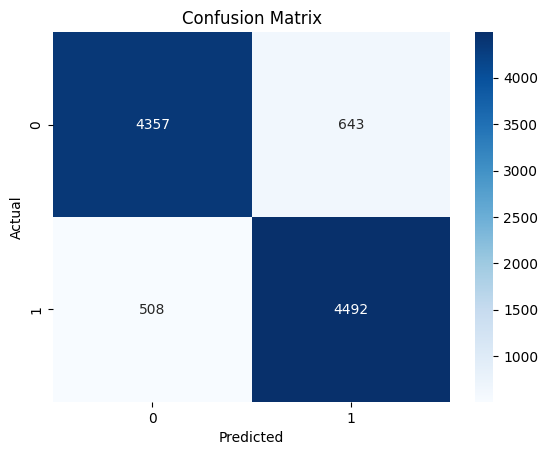

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
sample_reviews = [
    "I absolutely loved this movie, it was a masterpiece!",
    "This was the worst film I've ever seen."
]

sample_features = tfidf.transform(sample_reviews)
predictions = model.predict(sample_features)

for review, label in zip(sample_reviews, predictions):
    print(f"Review: {review}")
    print("Sentiment:", "Positive" if label == 1 else "Negative", "\n")


Review: I absolutely loved this movie, it was a masterpiece!
Sentiment: Positive 

Review: This was the worst film I've ever seen.
Sentiment: Negative 



In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8531


In [ ]:
import joblib

# Save the model and vectorizer
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!


In [ ]:
# Load the model
model = joblib.load("sentiment_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Example test
text = ["I really love this movie!"]
text_tfidf = tfidf.transform(text)
pred = model.predict(text_tfidf)

print("Prediction:", pred[0])


Prediction: 1


In [ ]:
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    pred = model.predict(text_tfidf)
    return "Positive 😊" if pred[0] == 1 else "Negative 😞"

print(predict_sentiment("This product is amazing!"))
print(predict_sentiment("Worst experience ever!"))

Positive 😊
Negative 😞
